This notebook attempts to use only top 25 important factors


In [152]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import patsy
from IPython.core.pylabtools import figsize
from scipy.stats import bernoulli

MSH = os.getenv('MSH')

import sys
sys.path.append('{0}/../'.format(MSH))

from common_libs.db_conn import DBConn
from MSH.model import ChurnModel  # My Random Forest model
from lifelines import CoxPHFitter, KaplanMeierFitter, AalenAdditiveFitter
from lifelines.utils import k_fold_cross_validation
from sklearn.preprocessing import StandardScaler

# get rid of pesky pandas warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.style.use('ggplot')

In [3]:
# load a pre-fitted Random Forest model & load the already processed data

model = ChurnModel('clean.customer_attributes_clipped')
model.load_saved_model('output/model.pkl')
_ = model._custom_preprocessing()


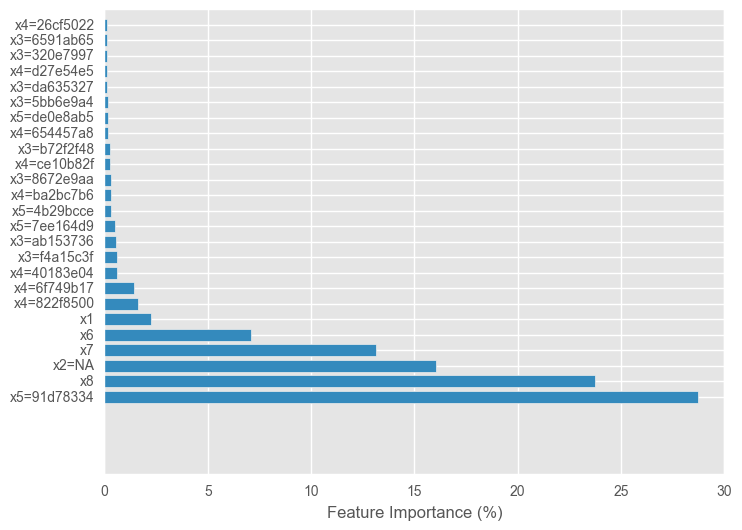

In [140]:
# find the top 25 most important features to the fit

figsize(8, 6)
top25_idx = np.argsort(-model.model.named_steps['random_forest'].feature_importances_)[:25]
top25_values = model.model.named_steps['random_forest'].feature_importances_[top25_idx] * 100

data = model.data_processed
data.rename(columns=lambda x: x.replace('<NA>', 'NA'), inplace=True)  # <> symbols break patsy.dmatrix()


top25_labels = data.columns[top25_idx].tolist()
top25_labels_pretty = [x.replace('_', '=') for x in top25_labels]  # clean up the feature name

# plot relative importance of each feature
plt.clf()

N_features = len(top25_idx)
y = range(N_features)

plt.barh(y, top25_values, tick_label=top25_labels_pretty, align='center')
plt.xlabel('Feature Importance (%)')

plt.savefig('feature_importances.png')

In [9]:
# 1.  construct the design matrix from the top 25 most important features
# 2.  perform pre-processing steps (mean subtract + STDDEV normalize)
# 3.  Add labels

# fill missing values with mean value
numerical_cols = [x for x in top25_labels if '_' not in x]
cat_cols = [x for x in top25_labels if '_' in x]

fill_dict = {
    name: data[name].mean() for name in numerical_cols
}

data.fillna(value=fill_dict, inplace=True)

X = patsy.dmatrix(' + '.join(top25_labels) + '- 1', data, return_type='dataframe')

# feature scaling on numerical features
scaler = StandardScaler()

numerical_data = X[numerical_cols]
X_num = scaler.fit_transform(numerical_data)

numerical_data_trans = pd.DataFrame(X_num, index=numerical_data.index, columns=numerical_cols)
X.update(numerical_data_trans)

# add duration + censorship labels
X['duration'] = model.data.days_since_signup
X['observed'] = model.data.status.apply(lambda x: 1 if x == 'canceled' else 0)


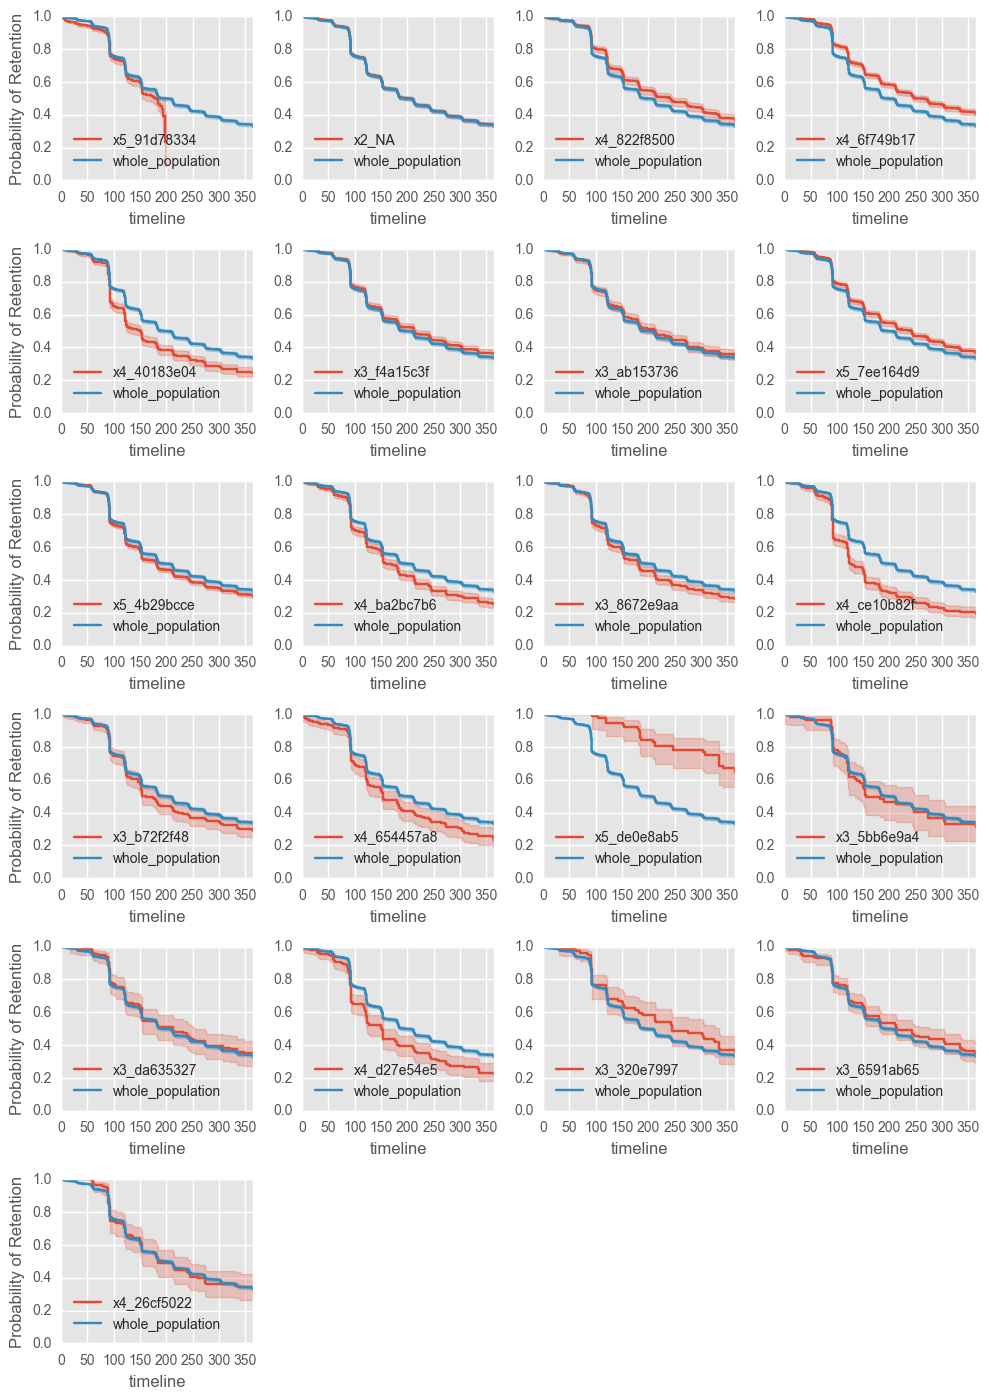

In [162]:
# Plot survival curves for the categorical features in the top 10 list


kmf= KaplanMeierFitter()
figsize(10, 16)

i = 0
for col in top25_labels:
    if col in cat_cols:
        ax = plt.subplot(7, 4, i + 1)
        subset = X.loc[X[col] == 1]
        kmf.fit(subset['duration'], subset['observed'], label=col)
        kmf.plot(ax=ax)
        kmf.fit(X['duration'], X['observed'], label='whole_population')
        kmf.plot(ax=ax)
        plt.xlim([0, 365])
        plt.ylim([0, 1])
        
        if i % 4 == 0:
            plt.ylabel('Probability of Retention')
        
        i += 1
    
plt.tight_layout()
plt.savefig('survival_curves.png')

 - *x5_91d78334* has a significantly higher hazard function than the population
 - *x2 = NA* has little difference from baseline hazard, probably because it correlates very closely with it.  This may be why it's a top feature from the RF model

In [44]:
def fit_cox_model(X, N=10):
    # use CV to find the optimal value for regularization
    
    reg_params = np.logspace(-1, 2, num=N)
    
    cv_scores = np.zeros(N)
    for i, p in enumerate(reg_params):
        print('Fitting model {0} of {1}'.format(i + 1, N))
        cox = CoxPHFitter(penalizer=p, normalize=False)
        scores = k_fold_cross_validation(cox, X, 'duration', 'observed', k=5)
        cv_scores[i] = np.mean(scores)
        
    best_model_idx = np.argmax(cv_scores)    
    print('Best model has mean concordance of {0}, using penalizer {1}'\
          .format(cv_scores[best_model_idx], reg_params[best_model_idx]
    ))
    
    best_model = CoxPHFitter(penalizer=reg_params[best_model_idx], normalize=False)
    best_model.fit(X, 'duration', 'observed')
    
    return best_model
        

In [47]:
cox_model = fit_cox_model(X)

Fitting model 1 of 10
Fitting model 2 of 10
Fitting model 3 of 10
Fitting model 4 of 10
Fitting model 5 of 10
Fitting model 6 of 10
Fitting model 7 of 10
Fitting model 8 of 10
Fitting model 9 of 10
Fitting model 10 of 10
Best model has mean concordance of 0.5927147267401685, using penalizer 0.46415888336127786


In [49]:
cox_model.print_summary()

n=9751, number of events=6431

                  coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
x5_91d78334  4.614e-01  1.586e+00 9.701e-02  4.756e+00 1.975e-06   2.712e-01   6.515e-01  ***
x8          -1.377e-02  9.863e-01 1.271e-02 -1.084e+00 2.785e-01  -3.869e-02   1.114e-02     
x2_NA        1.618e-02  1.016e+00 7.770e-02  2.082e-01 8.350e-01  -1.361e-01   1.685e-01     
x7          -8.980e-02  9.141e-01 1.633e-02 -5.497e+00 3.853e-08  -1.218e-01  -5.778e-02  ***
x6          -5.604e-02  9.455e-01 1.572e-02 -3.566e+00 3.628e-04  -8.685e-02  -2.523e-02  ***
x1          -1.599e-02  9.841e-01 1.623e-02 -9.851e-01 3.246e-01  -4.780e-02   1.583e-02     
x4_822f8500 -1.199e-01  8.870e-01 6.726e-02 -1.783e+00 7.465e-02  -2.518e-01   1.196e-02    .
x4_6f749b17 -1.889e-01  8.278e-01 6.393e-02 -2.955e+00 3.125e-03  -3.143e-01  -6.360e-02   **
x4_40183e04  2.921e-01  1.339e+00 6.964e-02  4.195e+00 2.733e-05   1.556e-01   4.286e-01  ***
x3_f4a15c3f -9.212e-02  9.120

This puts a quantitative spin on the intuitions from the Kaplan-Meier plots above.  e.g.:
  - customers who have x5=91d78334 are 58% more likely to churn than the baseline hazard
  - Similarly customers with x4=40183e04 are 34% more likeliy to churn
  - On the other hand, customers with x5=de0e8ab5 are 42% more likely to be retained
  
Again, x2=NA is almost identical to the baseline hazard

In [151]:
# looking at the numeric features.
x7_coef = 9.141e-01
x6_coef = 9.455e-01

# need to undo the feature scaling for this to be interpretable

x7_std = data.x7.std()
x6_std = data.x6.std()

print("for every increase in x7 of {0}, the hazard is multiplied by a factor of {1}".format(x7_std, x7_coef))
print("for every increase in x6 of {0}, the hazard is multiplied by a factor of {1}".format(x6_std, x6_coef))

for every increase in x7 of 6.1354096979431025, the hazard is multiplied by a factor of 0.9141
for every increase in x6 of 4.3475344158775435, the hazard is multiplied by a factor of 0.9455


In [131]:
# sync up individual customers' survival curves with current date (Jan 14, 2016) and project forward

preds = cox_model.predict_survival_function(X)

# re-index and interpolate between known durations
n_days_max = 3000

preds = preds.reindex(index=np.arange(n_days_max))
preds.interpolate(method='linear', inplace=True)

# predict current customer's churn at T + 90 days
current_users = model.data[model.data.status == 'active']

t_predict = 90

for uid, row in current_users.iterrows():
    current_users.loc[uid, 'S(t=90)'] = preds.loc[t_predict + row.days_since_signup, uid]
    current_users.loc[uid, 'S(t=0)'] = preds.loc[row.days_since_signup, uid]

current_users['P_churn(t=90)'] = current_users['S(t=0)'] - current_users['S(t=90)']


expected number of customers that will churn is 512.135
95% credibility interval is (473.0, 555.0)


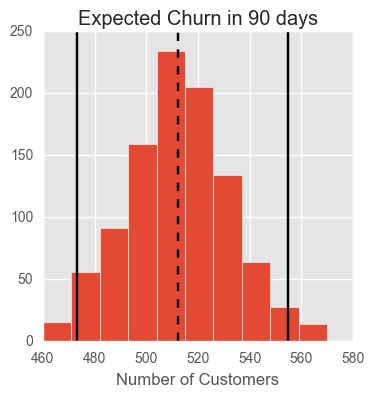

In [142]:
# Now that we have P(Churn) for N customers, simulate the results of N Bernoulli trials (with varying p)
# Since p is different for each customer, this is not a Binomial Distribution, it's a Poisson Binomial.  
# Let's simulate it 

figsize(4, 4)

n_realizations = 1000
n_users = len(current_users)

sims = np.zeros((n_users, n_realizations))
for i, (uid, row) in enumerate(current_users.iterrows()):
    sims[i, :] = bernoulli.rvs(p=row['P_churn(t=90)'], size=n_realizations)

expected_number_of_churns = sims.mean(axis=1).sum()
churn_dist = sims.sum(axis=0)
plt.hist(churn_dist)

s = np.sort(churn_dist)
lower_bound = s[int(.025 * n_realizations)]
upper_bound = s[int(.975 * n_realizations)]

print('expected number of customers that will churn is {0}'.format(expected_number_of_churns))
print('95% credibility interval is ({0}, {1})'.format(lower_bound, upper_bound))

ax = plt.gca()
ymin, ymax = ax.get_ylim()
ax.vlines(lower_bound, ymin, ymax)
ax.vlines(upper_bound, ymin, ymax)

ax.vlines(expected_number_of_churns, ymin, ymax, linestyles='dashed')
ax.set_title('Expected Churn in 90 days')
ax.set_xlabel('Number of Customers')

plt.savefig('churn_prediction.png')

In [158]:
# 100 customers most at risk of churning in 90 days
current_users.sort_values('P_churn(t=90)', ascending=False)[:100]

# save to file
with open('customers.pkl', 'wb') as fp:
    pickle.dump(current_users.sort_values('P_churn(t=90)', ascending=False)[:100], fp)
